# Transformer
[Offical Tutorial](https://www.tensorflow.org/tutorials/text/transformer)  
[Koeran Blog](https://nlpinkorean.github.io/illustrated-transformer/)  
Attention is all you need [paper<img src=./images/paper.png width=18>](https://arxiv.org/abs/1706.03762)  
This tutorial trains a Transformer model to <font color=red>translate Portuguese to English</font>.

**Positives +:** Several Advantages of using Transformer
* Layer outputs can be calculated in parallel.
* Distant items can affect each other's output without passing through RNN-steps, or convolution layers
* It can learn long-range dependencies.

**Negatives -:** Several Disadvantages
* For a time-series, the output for a time-step is calculated from the entire history, so it is inefficient.
* If the input does have a temporal/spatial relationship, like text, some positional encoding must be added or the model will effectively see a bag of words.

In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

for using GPU, I do not use `tf-nighly` library c.f. [tf-nightly 란?](https://devlog.jwgo.kr/2019/10/25/what-is-gpg-file-extension/)

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow_datasets as tfds
import tensorflow as tf
import time, sys
import numpy as np
import matplotlib.pyplot as plt

In [3]:
tf.__version__

'2.0.0'

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# GPU 메모리 제한하기
MEMORY_LIMIT_CONFIG = [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)]
print(MEMORY_LIMIT_CONFIG)
print(gpus)
tf.config.experimental.set_virtual_device_configuration(gpus[0], MEMORY_LIMIT_CONFIG)

[VirtualDeviceConfiguration(memory_limit=4096)]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Preprocessing
[TFDS](https://medium.com/tensorflow/introducing-tensorflow-datasets-c7f01f7e19f3) are used to load Portugese-English translation dataset  
This dataset contains approximately **50000 training examples, 1100 validation examples, and 2000 test examples.**

In [5]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True, as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

In [6]:
examples

{'test': <_OptionsDataset shapes: ((), ()), types: (tf.string, tf.string)>,
 'train': <_OptionsDataset shapes: ((), ()), types: (tf.string, tf.string)>,
 'validation': <_OptionsDataset shapes: ((), ()), types: (tf.string, tf.string)>}

In [7]:
train_examples

<_OptionsDataset shapes: ((), ()), types: (tf.string, tf.string)>

In [8]:
iter(train_examples).next()

(<tf.Tensor: id=168, shape=(), dtype=string, numpy=b'os astr\xc3\xb3nomos acreditam que cada estrela da gal\xc3\xa1xia tem um planeta , e especulam que at\xc3\xa9 um quinto deles tem um planeta do tipo da terra que poder\xc3\xa1 ter vida , mas ainda n\xc3\xa3o vimos nenhum deles .'>,
 <tf.Tensor: id=169, shape=(), dtype=string, numpy=b"astronomers now believe that every star in the galaxy has a planet , and they speculate that up to one fifth of them have an earth-like planet that might be able to harbor life , but we have n't seen any of them .">)

In [9]:
tokenizer_en = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for pt, en in train_examples), target_vocab_size=2**13)

tokenizer_pt = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (pt.numpy() for pt, en in train_examples), target_vocab_size=2**13)

In [10]:
print(tokenizer_en, tokenizer_pt)

<SubwordTextEncoder vocab_size=8087> <SubwordTextEncoder vocab_size=8214>


In [11]:
vars(tokenizer_en).keys()

dict_keys(['_subwords', '_subword_to_id', '_max_subword_len', '_cache_size', '_token_to_ids_cache', '_tokenizer'])

In [12]:
# import inspect
# inspect.getmembers(tokenizer_en, predicate=inspect.ismethod)

In [13]:
tokenizer_en

<SubwordTextEncoder vocab_size=8087>

In [14]:
sample_string = 'Transformer is awesome.'
# Encodes text into a list of integers.
tokenized_string = tokenizer_en.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))
# Decodes a list of integers into text.
original_string = tokenizer_en.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

assert original_string == sample_string

Tokenized string is [7915, 1248, 7946, 7194, 13, 2799, 7877]
The original string: Transformer is awesome.


In [15]:
for ts in tokenized_string:
    print ('{} ----> {}'.format(ts, tokenizer_en.decode([ts])))

7915 ----> T
1248 ----> ran
7946 ----> s
7194 ----> former 
13 ----> is 
2799 ----> awesome
7877 ----> .


In [16]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

Add a start and end token to the input and target.
`start id = vocab.size` and `end id = vocab.size + 1`

In [17]:
def encode(lang1, lang2):
    lang1 = [tokenizer_pt.vocab_size] + tokenizer_pt.encode(lang1.numpy()) + [tokenizer_pt.vocab_size+1]
    lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(lang2.numpy()) + [tokenizer_en.vocab_size+1]
    return lang1, lang2

You want to use [Dataset.map](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) to apply this function to each element of the dataset.  
Dataset.map runs in graph mode.  
Note that 
* Graph tensors do not have a value.
* In graph mode you can only use TensorFlow Ops and functions. 

So, So you can't .map this function directly: You need to wrap it in a [tf.py_function](https://www.tensorflow.org/api_docs/python/tf/py_function)  
This function allows expressing computations in a TensorFlow graph as Python functions.

In [18]:
def tf_encode(pt, en):
    result_pt, result_en = tf.py_function(func=encode, inp=[pt, en], Tout=[tf.int64, tf.int64])
    result_pt.set_shape([None])
    result_en.set_shape([None])
    return result_pt, result_en

In [19]:
MAX_LENGTH = 40

In [20]:
def filter_max_length(x, y, max_length=MAX_LENGTH):
    return tf.logical_and(tf.size(x) <= max_length, tf.size(y) <= max_length)

`padded_batch(..)` does not work in tensorflow-gpu==2.0.0  
`fixed padded_batch(..) issue in tensorflow-gpu==2.0.0` from [stackoverflow](https://stackoverflow.com/questions/55862178/attributeerror-shuffledataset-object-has-no-attribute-output-shapes-when)

In [21]:
train_dataset = train_examples.map(tf_encode)
train_dataset = train_dataset.filter(filter_max_length)

In [22]:
iter(train_dataset).next()

(<tf.Tensor: id=207355, shape=(14,), dtype=int64, numpy=
 array([8214,    7,  261,    8,    5,  188, 3247, 7990,  254,    9,  921,
         196,    2, 8215])>,
 <tf.Tensor: id=207356, shape=(17,), dtype=int64, numpy=
 array([8087, 4670, 1783,    1, 7936,    8,   74,  207,  996,   47,  251,
           6,   32,  219,   79,    2, 8088])>)

In [23]:
# cache the dataset to memory to get a speedup while reading from it.
train_dataset = train_dataset.cache()

In [24]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(train_dataset))
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

val_dataset = val_examples.map(tf_encode)
val_dataset = val_dataset.filter(filter_max_length).padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(val_dataset))

In [25]:
pt_batch, en_batch = next(iter(val_dataset))
pt_batch, en_batch

(<tf.Tensor: id=207710, shape=(64, 40), dtype=int64, numpy=
 array([[8214, 1259,    5, ...,    0,    0,    0],
        [8214,  299,   13, ...,    0,    0,    0],
        [8214,   59,    8, ...,    0,    0,    0],
        ...,
        [8214,   95,    3, ...,    0,    0,    0],
        [8214, 5157,    1, ...,    0,    0,    0],
        [8214, 4479, 7990, ...,    0,    0,    0]])>,
 <tf.Tensor: id=207711, shape=(64, 40), dtype=int64, numpy=
 array([[8087,   18,   12, ...,    0,    0,    0],
        [8087,  634,   30, ...,    0,    0,    0],
        [8087,   16,   13, ...,    0,    0,    0],
        ...,
        [8087,   12,   20, ...,    0,    0,    0],
        [8087,   17, 4981, ...,    0,    0,    0],
        [8087,   12, 5453, ...,    0,    0,    0]])>)

## Positional Encoding

Since this model doesn't contain any recurrence or convolution, positional encoding is added to give the model some information about the **relative position** of the words in the sentence.  
So after adding the positional encoding, words will be closer to each other based on the similarity of their meaning and their position in the sentence, in the d-dimensional space.
See the notebook on [positional encoding](https://github.com/tensorflow/examples/blob/master/community/en/position_encoding.ipynb) to learn more about it.  

$$
\begin{align}
PE(pos, 2i) &= sin(pos/ 10000^{\frac{2i}{d_{model}}}) \\
PE(pos, 2i+1) &= cos(pos/ 10000^{\frac{2i}{d_{model}}})
\end{align}
$$

In [26]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

In [27]:
angle_rads = get_angles(np.arange(50)[:, np.newaxis],
                          np.arange(512)[np.newaxis, :],
                          512)

In [28]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model) # (50, 512)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2]) # (50, 256)
    
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2]) # (50, 256)

    pos_encoding = angle_rads[np.newaxis, ...] # (1, 50, 256)

    return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


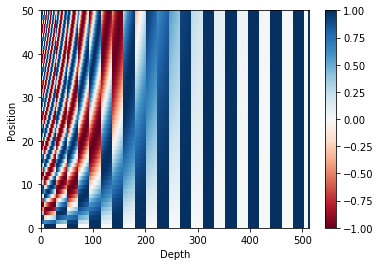

In [29]:
pos_encoding = positional_encoding(50, 512)
print(pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## Masking
Mask all the pad tokens in the batch of sequence.  
The mask indicates **where pad value 0 is present: it outputs a 1 at those locations, and a 0 otherwise.**

In [30]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [31]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: id=207725, shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

The **look-ahead mask** is used to mask the future tokens in a sequence.   
In other words, the mask indicates which entries should not be used.    
This means that to predict the third word, only the first and second word will be used.  
Similarly to predict the fourth word, only the first, second and the third word will be used and so on.
> Self-Attention 계산과정에서 masking하는데 사용될 수 있다.

In [32]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

In [33]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: id=207740, shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

## Scaled Dot Attention

<img src='./images/scaled_attention.png' width='250'>
$$
Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}V)
$$

The dot-product attention is scaled by a factor of square root of the depth. This is done because for large values of depth, the dot product grows large in magnitude pushing the softmax function where it has small gradients resulting in a very hard softmax.  

The mask is multiplied with `-1e9` (close to negative infinity). This is done because the mask is summed with the scaled matrix multiplication of Q and K and is applied immediately before a softmax. The goal is to zero out these cells, and large negative inputs to softmax are near zero in the output.

<font color=red> Note that </font>
* `seq_len_k = seq_len_v`
* `q.depth = k.depth`

In [34]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead) 
    but it must be broadcastable for addition.

    Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
    output, attention_weights
    """
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk) # (..., seq_len_q, seq_len_k)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)
    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

In [35]:
def print_out(q, k, v):
    temp_out, temp_attn = scaled_dot_product_attention(q, k, v, None)
    print ('Attention weights are:')
    print (temp_attn)
    print ('Output is:')
    print (temp_out)

In [36]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3), only one example.
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [37]:
# This query aligns with a repeated key (third and fourth), 
# so all associated values get averaged.
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [38]:
# This query aligns equally with the first and second key, 
# so their values get averaged.
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


In [39]:
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


## Multi-Head Attention
<img src='./images/multi_head_attention.png' width=250>

Multi-head attention consists of four parts:  
* Linear layers and split into heads.  
* Scaled dot-product attention.  
* Concatenation of heads.  
* Final linear layer.  

The `scaled_dot_product_attention` defined above is applied to each head (broadcasted for efficiency)

The **Multi-head attention** allows the model to jointly attend to information at different positions from different representational spaces. After the split each head has a reduced dimensionality, so the total computation cost is the same as a single head attention with full dimensionality.

<font color=red>Requirement: </font> `d_model = num_heads * depth`

In [40]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0 # mod 값이 0 이어야한다.

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(units=d_model)
        self.wk = tf.keras.layers.Dense(units=d_model)
        self.wv = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)
        
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3]) # (batch_size, num_heads, seq_len, depth)
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)
        concat_attention = tf.reshape(scaled_attention, shape=(batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights

In [41]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

In [42]:
tmp_v = tf.random.uniform((5, 40, 512))
tmp_k = tf.random.uniform((5, 40, 512))
tmp_q = tf.random.uniform((5, 60, 512))
out, attn = temp_mha(tmp_v, k=tmp_k, q=tmp_q, mask=None)
out.shape, attn.shape

(TensorShape([5, 60, 512]), TensorShape([5, 8, 60, 40]))

## Point-Wise Feed Forward Network
Point wise feed forward network consists of two fully-connected layers with a ReLU activation in between.  
`dff` (deep feed forward network units)


In [43]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)])  # (batch_size, seq_len, d_model)

In [44]:
# example 
sample_ffn = point_wise_feed_forward_network(d_model=512, dff=2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

## Encoder and Decoder

<img src='./images/transformer.png' width=300>

The transformer model follows the same general pattern as a standard [sequence to sequence with attention model](https://www.tensorflow.org/tutorials/text/nmt_with_attention).
* The input sentence is passed through **N** encoder layers that generates an output for each word/token in the sequence.
* The decoder attends on the encoder's output and its own input (self-attention) to predict the next word.

### Encoder layer
Each encoder layer consists of sublayers:
* Multi-head attention (with padding mask)
* Point wise feed forward networks.

Each of these sublayers has a residual connection around it followed by a layer normalization. Residual connections **help in avoiding the vanishing gradient problem** in deep networks.  
The output of each sublayer is LayerNorm(x + Sublayer(x)). The normalization is done on the d_model (last) axis.

In [45]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2

In [46]:
# example
sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)
sample_encoder_layer_output = sample_encoder_layer(tf.random.uniform((64, 43, 512)), training=False, mask=None)
sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

### Decoder layer
Each decoder layer consists of sublayers:
* Masked multi-head attention (**with look ahead mask and padding mask**)
* Multi-head attention (**with padding mask**). 
    * V (value) and K (key) receive the encoder output as inputs. 
    * Q (query) receives the output from the masked multi-head attention sublayer.
* Point wise feed forward networks

Each of these sublayers has a residual connection around it followed by a layer normalization.  
The output of each sublayer is LayerNorm(x + Sublayer(x)). The normalization is done on the d_model (last) axis.  
There are N decoder layers in the transformer.  

As Q receives the output from decoder's first attention block, and K receives the encoder output, the attention weights represent the importance given to the decoder's input based on the encoder's output. In other words, the decoder predicts the next word by looking at the encoder output and self-attending to its own output. See the demonstration above in the scaled dot product attention section.

In [47]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads) # self-attention
        self.mha2 = MultiHeadAttention(d_model, num_heads) # cross-attention
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        """ enc_output.shape == (batch_size, input_seq_len, d_model) """
        
        # self attention
        # attn1.shape=(batch_size, target_seq_len, d_model)
        # attn_wegihts_block1.shape=(batch_size, num_heads, target_seq_len, target_seq_len)
        attn1, attn_weights_block1 = self.mha1(x, k=x, q=x, mask=look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)
        
        # cross attention
        # attn2.shape=(batch_size, target_seq_len, d_model)
        # attn_wegihts_block2.shape=(batch_size, num_heads, input_seq_len, target_seq_len)
        attn2, attn_weights_block2 = self.mha2(enc_output, k=enc_output, q=out1, mask=padding_mask)  
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
        return out3, attn_weights_block1, attn_weights_block2

In [48]:
sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)

sample_decoder_layer_output, attw1 , attw2 = sample_decoder_layer(tf.random.uniform((64, 50, 512)), 
                                                         enc_output=sample_encoder_layer_output, 
                                                         training=False, look_ahead_mask=None, padding_mask=None)
sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

In [49]:
print(attw1.shape, attw2.shape)

(64, 8, 50, 50) (64, 8, 50, 43)


## Encoder
The Encoder consists of:
* Input Embedding
* Positional Encoding
* N encoder layers

<img src='./images/transformer.png' width=300>

> 궁금한점: max position encoding 값은 어떻게 정하는 거지?

In [50]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                 maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model) # (1, maximum_position_encoding, d_model)
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        """ input x.shape is (batch_size, input_seq_len)"""
        seq_len = tf.shape(x)[1]

        # adding embedding and position encoding.
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :] # (batch_size, input_seq_len, d_model)
        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
        return x  # (batch_size, input_seq_len, d_model)

In [51]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
# temp_input is a word-id list.
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


In [52]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
                 maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        """ input x.shape is (batch_size, target_seq_len)
        
        block 1 attention.shape is (batch_size, num_heads, target_seq_len, target_seq_len)
        block 2 attention.shape is (batch_size, num_heads, target_seq_len, enc_output_seq_len)
        """
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            # block 1 is self-attention weights, block2 is cross-attention weights
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)
      
        attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
        attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

### Decoder
The Decoder consists of:
* Output Embedding
* Positional Encoding
* N decoder layers

In [53]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input, 
                              enc_output=sample_encoder_output, 
                              training=False,
                              look_ahead_mask=None, 
                              padding_mask=None)

# only store for the last decoder layer
for k, v in attn.items():
    print('attn["{}"].shape is {}'.format(k, v.shape))
output.shape

attn["decoder_layer2_block1"].shape is (64, 8, 26, 26)
attn["decoder_layer2_block2"].shape is (64, 8, 26, 62)


TensorShape([64, 26, 512])

## Create the Transformer

Transformer consists of the encoder, decoder and a **final linear layer**. The output of the decoder is the input to the linear layer and its output is returned.

<img src='./images/transformer.png' width=400>

In [54]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
                 target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                               input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                               target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    def call(self, inp, tar, training, enc_padding_mask, 
             look_ahead_mask, dec_padding_mask):
        """ final_output is translated sequence and attention weights(dictionary) of the last layer of the decoder"""
        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape=(batch_size, tar_seq_len, d_model)
        # attention_weights['first'].shape=(batch_size, num_heads, tar_seq_len, tar_seq_len)
        # attention_weights['second'].shape=(batch_size, num_heads, tar_seq_len, inp_seq_len)
        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights

**Example**: predict next-step sequence to translate a sentence!

In [55]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_vocab_size=8500, target_vocab_size=8000, 
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

## Hyperparameters

To keep this example small and relatively fast, the values for num_layers, d_model, and dff have been reduced.  
The values used in the base model of transformer were; num_layers=6, d_model = 512, dff = 2048. See the [paper](https://arxiv.org/abs/1706.03762) for all the other versions of the transformer.

In [56]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer_pt.vocab_size + 2
target_vocab_size = tokenizer_en.vocab_size + 2
dropout_rate = 0.1

## Optimizer

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the [paper](https://arxiv.org/abs/1706.03762).  
$$
    l_{rate} = d_{model}^{-0.5} * min(step_{num}^{-0.5}, step_{num} * warmup_{steps}^{-1.5} )
$$

In [57]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [58]:
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

Text(0.5, 0, 'Train Step')

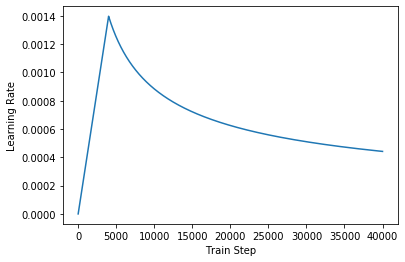

In [59]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## Loss and Metric

<font color=red>Since the target sequences are padded</font>, it is important to apply a padding mask when calculating the loss.

In [60]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [61]:
# example
cce = tf.keras.losses.SparseCategoricalCrossentropy()
print(cce(tf.convert_to_tensor([0, 1, 2]), tf.convert_to_tensor([[.9, .05, .05], [.5, .89, .6], [.05, .01, .94]])))
cce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
print(cce(tf.convert_to_tensor([0, 1, 2]), tf.convert_to_tensor([[.9, .05, .05], [.5, .89, .6], [.05, .01, .94]])))

tf.Tensor(0.32396814, shape=(), dtype=float32)
tf.Tensor(0.6981444, shape=(), dtype=float32)


In [62]:
# example
loss = loss_object(tf.convert_to_tensor([0, 1, 2]), tf.convert_to_tensor([[.9, .05, .05], [.5, .89, .6], [.05, .01, .94]]))

In [63]:
def loss_function(real, pred):
    loss_ = loss_object(y_true=real, y_pred=pred)
    mask = tf.cast(tf.math.logical_not(tf.math.equal(real, 0)), dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

In [64]:
# update_state(..) will be used 
train_loss = tf.keras.metrics.Mean(name='train_loss') # update_state([list of losses])
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy') # # update_state(y_real_label=[..], y_pred_onehot=[..])

In [65]:
# example
print(train_loss.update_state(loss))
print(train_loss.result().numpy())
# simply like this
print(train_loss(loss))

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=3.0>
0.6981444
tf.Tensor(0.6981444, shape=(), dtype=float32)


In [66]:
# example: update and accuracy of accumulated accuracy
train_accuracy(y_true=tf.convert_to_tensor([0, 1, 1]), 
               y_pred=tf.convert_to_tensor([[.9, .05, .05], [.5, .89, .6], [.05, .01, .94]]))

<tf.Tensor: id=212994, shape=(), dtype=float32, numpy=0.6666667>

## Train and Checkpoint

In [67]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

recall that inp, tar batch, they are masked by `pad_id = 0`

In [68]:
def create_masks(inp, tar):
    """ inp and tar are squences of id, where padding id is 0
    returns
        enc_padding_mask # (batch_size, 1, 1, enc_seq_len)
        combined_mask # (batch_size, 1, tar_seq_len, tar_seq_len)
        dec_padding_mask # (batch_size, 1, 1, enc_seq_len)
    """
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp) # (batch_size, 1, 1, enc_seq_len)

    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp) # (batch_size, 1, 1, enc_seq_len)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by 
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1]) # (tar_seq_len, tar_seq_len)
    dec_target_padding_mask = create_padding_mask(tar)   # (batch_size, 1, 1, tar_seq_len)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask) # (batch_size, 1, tar_seq_len, tar_seq_len)
    return enc_padding_mask, combined_mask, dec_padding_mask

Create the checkpoint path and the checkpoint manager. This will be used to save checkpoints every n epochs.

In [69]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(checkpoint=ckpt, directory=checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [70]:
# inference example for a minibatch
print('inp.shape = {} | tar.shape = {}'.format(pt_batch.shape, en_batch[:,:-1].shape))
mask1, mask2, mask3 = create_masks(pt_batch, en_batch[:,:-1])
out, _ = transformer(pt_batch, tar=en_batch[:,:-1], training=False, 
                     enc_padding_mask=mask1, 
                     look_ahead_mask=mask2, 
                     dec_padding_mask=mask3)
out.shape

inp.shape = (64, 40) | tar.shape = (64, 39)


TensorShape([64, 39, 8089])

In [71]:
tokenizer_en.vocab_size

8087

In [73]:
idx = 10
tf.argmax(out[idx], axis=1)

<tf.Tensor: id=219576, shape=(39,), dtype=int64, numpy=
array([  16,   13,   95,   12, 1605,   52,   12,  271,   11, 5121,    1,
       1226, 1141, 3984,    6,    6,    3,  879, 1811, 7936,  879, 1490,
          2, 8088,    2,    2,    2,    2,    2,    2,    2,    2,    2,
          2,    2,    2,    2,    2,    2])>

In [74]:
def decode_example(example, tokenizer):
    """ example is an example in a minibatch """
    t = []
    for w in example:
        if w >= tokenizer.vocab_size: break
        t.append(w.numpy())
    return t

In [75]:
tmp = decode_example(pt_batch[idx][1:], tokenizer_pt)
print('[inputed as follows]:\n{}\n{}'.format(tmp, tokenizer_pt.decode(tmp)))

tmp = decode_example(tf.argmax(out[idx], axis=1), tokenizer_en)
print('[translated as follows]:\n{}\n{}'.format(tmp, tokenizer_en.decode(tmp)))

[inputed as follows]:
[8, 84, 5, 27, 3045, 28, 27, 5590, 22, 4573, 1, 117, 1163, 1978, 15, 2469, 2675, 4, 367, 1696, 735, 2]
é aqui que eu vivo . eu vivo no quénia , nas partes sul do parque nacional de nairobi .
[translated as follows]:
[16, 13, 95, 12, 1605, 52, 12, 271, 11, 5121, 1, 1226, 1141, 3984, 6, 6, 3, 879, 1811, 7936, 879, 1490, 2]
this is where i live . i live in kenya , among south southern of of the national robinational park .


The target is divided into tar_inp and tar_real. tar_inp is passed as an input to the decoder. tar_real is that same input shifted by 1: At each location in tar_input, tar_real contains the next token that should be predicted.

For example, sentence = "SOS A lion in the jungle is sleeping EOS"
tar_inp = "SOS A lion in the jungle is sleeping"
tar_real = "A lion in the jungle is sleeping EOS"

The transformer is an auto-regressive model: it makes predictions one part at a time, and uses its output so far to decide what to do next.

During training this example uses <font color=red>teacher-forcing</font> (like in the [text generation tutorial](https://www.tensorflow.org/tutorials/text/text_generation)). Teacher forcing is passing the true output to the next time step regardless of what the model predicts at the current time step.

As the transformer predicts each word, self-attention allows it to look at the previous words in the input sequence to better predict the next word.

To prevent the model from peaking at the expected output the model uses a look-ahead mask.

In [76]:
EPOCHS = 1

In [77]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

# @tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1] # (batch_size, tar_seq_len - 1)
    tar_real = tar[:, 1:] # (batch_size, tar_seq_len - 1)
    
    # enc_padding_mask # (batch_size, 1, 1, enc_seq_len)
    # combined_mask # (batch_size, 1, tar_seq_len, tar_seq_len - 1)
    # dec_padding_mask # (batch_size, 1, 1, enc_seq_len)
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
    
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, 
                                     True, 
                                     enc_padding_mask, 
                                     combined_mask, 
                                     dec_padding_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(tar_real, predictions)

In [78]:
def print_progress(epoch, step, loss, acc):
    """ print progressive states """
    # Status-message. Note the \r which means the line should
    # overwrite itself.
    msg = "\r Train Phase - epoch: {0:} |step: {1:}|loss: {2:.3f}|acc: {3:.3f}".format(epoch, step, loss, acc)
    # Print it.
    sys.stdout.write(msg)
    sys.stdout.flush() 

In [79]:
for epoch in range(EPOCHS):
    start = time.time()
    
    # initialize tf.keras.metrics.* object
    train_loss.reset_states()
    train_accuracy.reset_states()
  
    # inp -> portuguese, tar -> english
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)
    
        # if batch % 50 == 0:
        #    print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, batch, train_loss.result(), train_accuracy.result()))
        print_progress(epoch + 1, batch, train_loss.result(), train_accuracy.result())
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch + 1, ckpt_save_path))
    
    # print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, train_loss.result(), train_accuracy.result()))
    # print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

 Train Phase - epoch: 1 |step: 702|loss: 0.410|acc: 0.369

## Evaluate
The following steps are used for evaluation:
* Encode the input sentence using the Portuguese tokenizer (tokenizer_pt). Moreover, add the start and end token so the input is equivalent to what the model is trained with. This is the encoder input.
* The decoder input is the start token == tokenizer_en.vocab_size.
* Calculate the padding masks and the look ahead masks.
* The decoder then outputs the predictions by looking at the encoder output and its own output (self-attention).
* Select the last word and calculate the argmax of that.
* Concatentate the predicted word to the decoder input as pass it to the decoder.
* In this approach, the decoder predicts the next word based on the previous words it predicted.

밑의 방식을 사용하여 디버깅을 할 수 있다.
```python
import pdb; pdb.set_trace() 
```

In [80]:
def evaluate(inp_sentence):
    """ inp_sentence is Portuguese sentence """
    start_token = [tokenizer_pt.vocab_size]
    end_token = [tokenizer_pt.vocab_size + 1]

    # inp sentence is portuguese, hence adding the start and end token
    inp_sentence = start_token + tokenizer_pt.encode(inp_sentence) + end_token
    encoder_input = tf.expand_dims(inp_sentence, 0) # shape=(1, 11)

    # as the target is english, the first word to the transformer should be the
    # english start token.
    decoder_input = [tokenizer_en.vocab_size]
    output = tf.expand_dims(decoder_input, 0) # shape=(1, 1)
    
    for i in range(MAX_LENGTH): # MAX_LENGTH = 40
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)

        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer(encoder_input, 
                                                     output,
                                                     False,
                                                     enc_padding_mask,
                                                     combined_mask,
                                                     dec_padding_mask)

        # select the last word from the seq_len dimension
        predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32) # (1, 1)

        # return the result if the predicted_id is equal to the end token
        if predicted_id == tokenizer_en.vocab_size+1:
            return tf.squeeze(output, axis=0), attention_weights

        # concatentate the predicted_id to the output which is given to the decoder
        # as its input.
        output = tf.concat([output, predicted_id], axis=-1)
        
        # debugger
        # import pdb; pdb.set_trace()

    return tf.squeeze(output, axis=0), attention_weights

In [81]:
print(tokenizer_pt.encode("este é um problema que temos que resolver.")) # len=9, later, start and end token will be imputed.
tokenizer_pt.decode(tokenizer_pt.encode("este é um problema que temos que resolver."))

[59, 8, 9, 261, 5, 62, 5, 4567, 8004]


'este é um problema que temos que resolver.'

In [82]:
# pt_batch.shape # [60, 40]
# evaluate(pt_batch)
ev, attn = evaluate("este é um problema que temos que resolver.")

In [83]:
# predicted output
print(ev)
tokenizer_en.decode(ev[1:])

tf.Tensor(
[8087   16   13    7  328   10   14   24    5 1902   19 7877 7877 7877
  302   63    8   74  141    5 1902    7  385    2], shape=(24,), dtype=int32)


"this is a problem that we have to fix it.... we 've got to fix a problem ."

In [84]:
for k, v in attn.items():
    print('{}.shape={}'.format(k, v.shape)) # v.shape=(batch_size, num_heads, seq_len_q, seq_len_k)

decoder_layer4_block1.shape=(1, 8, 24, 24)
decoder_layer4_block2.shape=(1, 8, 24, 11)


In [85]:
def plot_attention_weights(attention, sentence, result, layer):
    fig = plt.figure(figsize=(16, 8))
    sentence = tokenizer_pt.encode(sentence)
    attention = tf.squeeze(attention[layer], axis=0)

    for head in range(attention.shape[0]):
        ax = fig.add_subplot(2, 4, head + 1)
        # plot the attention weights
        ax.matshow(attention[head][:-1, :], cmap='viridis')
        fontdict = {'fontsize': 10}
        ax.set_xticks(range(len(sentence)+2))
        ax.set_yticks(range(len(result)))
        ax.set_ylim(len(result)-1.5, -0.5)
        ax.set_xticklabels(['<start>']+[tokenizer_pt.decode([i]) for i in sentence]+['<end>'], fontdict=fontdict, rotation=90)
        ax.set_yticklabels([tokenizer_en.decode([i]) for i in result if i < tokenizer_en.vocab_size], fontdict=fontdict)
        ax.set_xlabel('Head {}'.format(head+1))
  
    plt.tight_layout()
    plt.show()

In [86]:
def translate(sentence, plot=''):
    result, attention_weights = evaluate(sentence)
    predicted_sentence = tokenizer_en.decode([i for i in result if i < tokenizer_en.vocab_size])  

    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(predicted_sentence))
  
    if plot:
        plot_attention_weights(attention_weights, sentence, result, plot)

In [87]:
translate("este é um problema que temos que resolver.")
print ("Real translation: this is a problem we have to solve .")

Input: este é um problema que temos que resolver.
Predicted translation: this is a problem that we have to fix it.... we 've got to fix a problem .
Real translation: this is a problem we have to solve .


In [88]:
translate("os meus vizinhos ouviram sobre esta ideia.")
print ("Real translation: and my neighboring homes heard about this idea .")

Input: os meus vizinhos ouviram sobre esta ideia.
Predicted translation: my neighbors heard about this idea .
Real translation: and my neighboring homes heard about this idea .


In [89]:
translate("vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.")
print ("Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .")

Input: vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Predicted translation: so let me just share with you some stories of some magic things that had happened to be on.
Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .


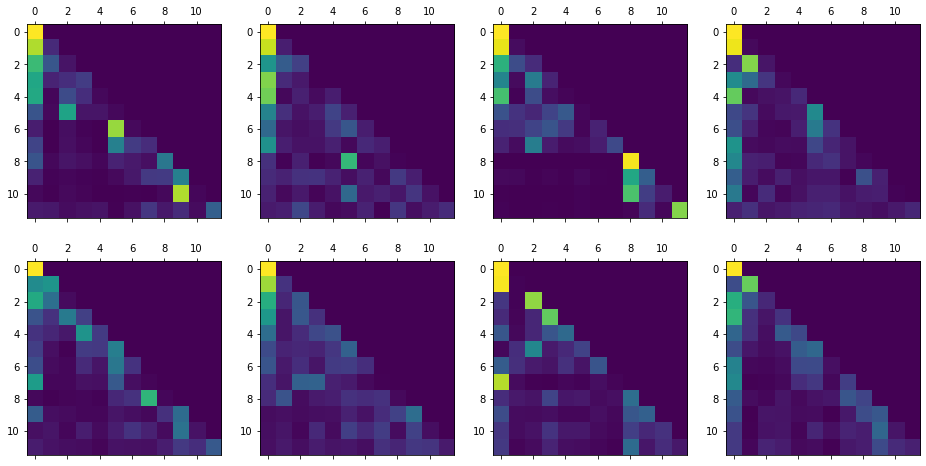

In [90]:
# multi-heads self-attention weight visualization (look-ahead mask was used)
ev, attn = evaluate("este é o primeiro livro que eu fiz.")
fig = plt.figure(figsize=(16, 8))
for h in range(8):
    ax = fig.add_subplot(2, 4, h + 1)
    ax.matshow(attn['decoder_layer4_block1'][0][h,:])

Input: este é o primeiro livro que eu fiz.
Predicted translation: this is the first book that i did.a .


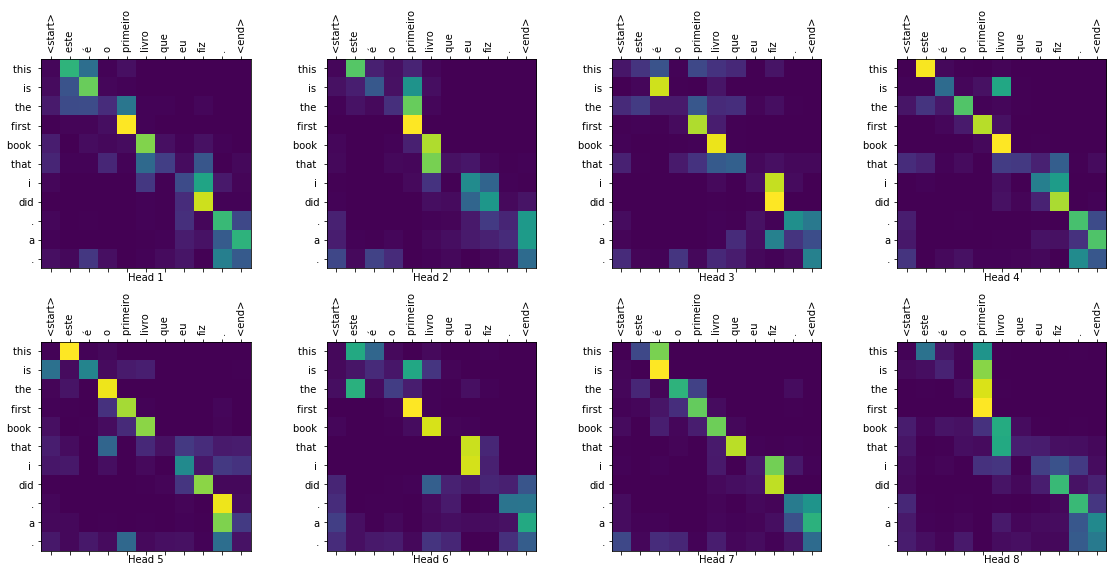

Real translation: this is the first book i've ever done.


In [91]:
# multi-heads cross-attention weight visualization
translate("este é o primeiro livro que eu fiz.", plot='decoder_layer4_block2')
print ("Real translation: this is the first book i've ever done.")